# Regression with multiple predictors: chess with nature II

### We can never know the whole truth of inscrutable Nature, we can only test our postulates against data, and improve them over time. 

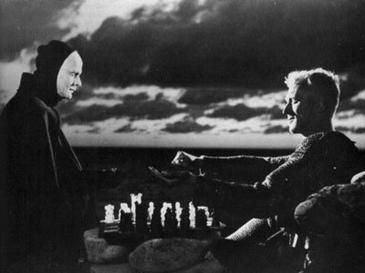

In [1]:
from IPython.display import Image
Image('https://upload.wikimedia.org/wikipedia/en/5/5f/Ingmar_Bergman-The_Seventh_Seal-01.jpg')

# The Dialogue
### Scientist: 
I have heard that in your mystery you have 2 flavors of El Nino: central Pacific and eastern Pacific, and that these impact us humans differently. 

### Nature: 
Maybe two flavors, or maybe two eyes on a face?
How will you distinguish, in your puny lifetimes, watching a few rolls of my dice? 

### Scientist: 
I shall extract time series of sea temperature at two longitudes on the equator, and see their correlation patterns with other things in other places. Move over, Sir Gilbert Walker! First let's grab all the data in a time-longitude file:  

In [4]:
%pylab inline
#plt.xkcd() # whiteboard style
from netCDF4 import Dataset

datafile = Dataset('Eq_timelon_sections.nc',mode='r')
for key in datafile.variables.keys(): 
    print( 'grabbing ' + key)
    exec( key +"=datafile['"+key+"'][:].squeeze()")
datafile.close()

Populating the interactive namespace from numpy and matplotlib
grabbing lon
grabbing time
grabbing olr
grabbing precip
grabbing slp
grabbing sst
grabbing uwnd


#### Now I grab CPAC and EPAC time series to use as predictors

Text(0.5,1,'CPAC and EPAC SST (240 mos, from Jan 1980)')

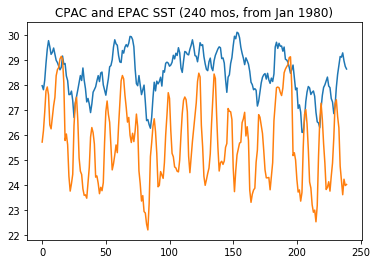

In [5]:
CPAC = sst[:,find(lon == 185)]
EPAC = sst[:,find(lon == 240)]
plot(CPAC); plot(EPAC); 
title('CPAC and EPAC SST (240 mos, from Jan 1980)')

Oops I better remove seasonality, since its web of causality around the globe (all variables are forced by the sun, everywhere) is totally different from the ocean sloshes of ENSO forcing the global atmosphere. 

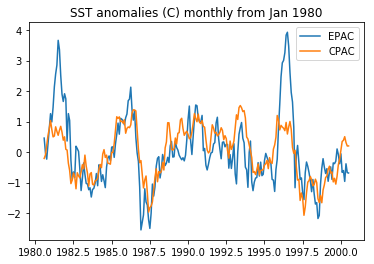

In [6]:
calmos = arange(12) ## Runs from 0-11, not 1-12, CAREFUL! 
months = arange(size(EPAC))
for imo in calmos:
    yess = find(imo == months%12)
    EPAC[yess] -= mean(EPAC[ yess ] )
    CPAC[yess] -= mean(CPAC[ yess ] )

# EPAC = EPAC*3 ### EXPERIMENT WITH MAGNITUDE TO CHECK LINREGRESS

yyyy = 1980 + time/12. + 0.5  
plot(yyyy, EPAC, label='EPAC'); 
plot(yyyy, CPAC, label='CPAC'); 
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

#### Hmm, they look rather similar. But there is a little bit of indepependent information. Wonder what the correlation is? 

0.64983976 0.69002205 1.3842258
Wow, shared variance is only  42.22917122121004 %


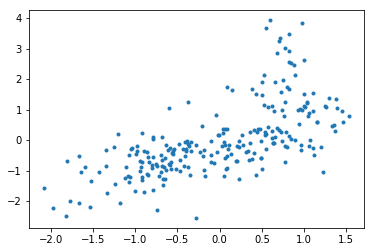

In [8]:
# corrcoef( transpose(CPAC), transpose(EPAC) )
cor = mean(CPAC*EPAC) / std(CPAC) / std(EPAC)
print( cor, var(CPAC), var(EPAC) )
print( 'Wow, shared variance is only ', 100*cor**2,'%' )
plot(CPAC,EPAC,'.')

In [10]:
import scipy, scipy.stats
# ?scipy.stats.linregress

# let's fit a line. Y regressed on X in (X,Y) calling order:   
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(transpose(CPAC),transpose(EPAC))
    
EfromC = intercept + slope*CPAC
print( slope, intercept )
print("r-squared:", r_value**2)

0.9204035546527781 1.194854812982678e-07
r-squared: 0.4222917246756723


/Users/bem/miniconda3/envs/ATMOcanes/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/bem/miniconda3/envs/ATMOcanes/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [13]:
slope, intercept, r_value, p_value, std_err = \
    scipy.stats.linregress(transpose(EPAC),transpose(CPAC))
 
CfromE = intercept + slope*EPAC
print( slope, intercept )
print("r-squared:", r_value**2)

0.45881148822266504 4.864456378339782e-09
r-squared: 0.4222917246756723


/Users/bem/miniconda3/envs/ATMOcanes/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/bem/miniconda3/envs/ATMOcanes/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


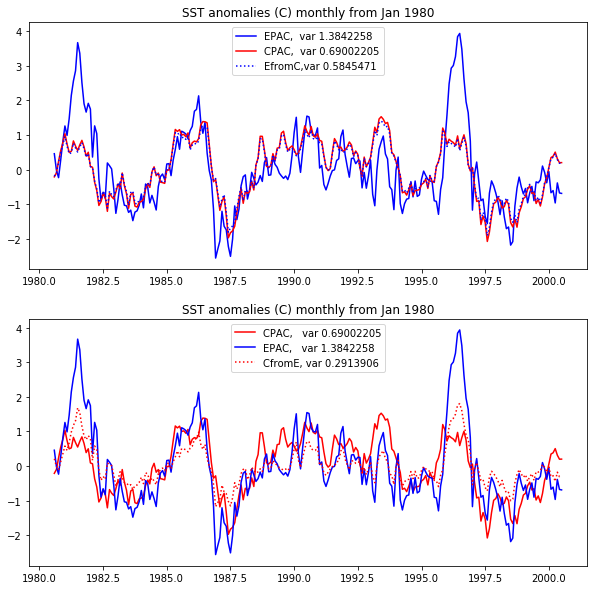

In [14]:
# Plot the indidvidual regressions

figure(figsize=[10,10])

subplot(211)
plot(yyyy, EPAC,  'b' , label='EPAC,  var '+str(var(EPAC)) )
plot(yyyy, CPAC,  'r' , label='CPAC,  var '+str(var(CPAC)) )
plot(yyyy, EfromC,'b:', label='EfromC,var '+str(var(EfromC)) )
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

subplot(212)
plot(yyyy, CPAC,  'r' , label='CPAC,   var '+str(var(CPAC)) )
plot(yyyy, EPAC,  'b' , label='EPAC,   var '+str(var(EPAC)) )
plot(yyyy, CfromE,'r:', label='CfromE, var '+str(var(CfromE)) )
title('SST anomalies (C) monthly from Jan 1980')
legend(loc='best')

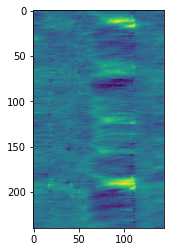

In [15]:
ssta = sst.copy() # anomaly array copy
for ilon in arange(len(lon)): 
    for imo in calmos:
        calmo = find(imo == months%12)
        ssta[calmo,ilon] -= mean( sst[calmo,ilon] )
imshow(ssta)

### Lag regressions of SST relative to each series. 
#### Define the 'result' array. Then fill it with a loop. Then display it. 

In [17]:
# Longitude-lag arrays are the results space
lags = arange(-12,13,1)
print(lags)
Covs_fromC = zeros( (len(lags), len(lon))  )
Covs_fromE = zeros( (len(lags), len(lon))  )
Corrs_fromC = zeros( (len(lags), len(lon))  )
Corrs_fromE = zeros( (len(lags), len(lon))  )

[-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12]


In [18]:
for ilag in arange(len(lags)): 
#    print 'lag ',lags[ilag]
    for ilon in arange(len(lon)):
        
        ts1 = roll(CPAC,lags[ilag]).squeeze()
        ts2 = ssta[:,ilon].squeeze()

        Covs_fromC[ilag,ilon]  = mean(ts1*ts2)
        Corrs_fromC[ilag,ilon] = mean(ts1*ts2) /std(ts1)/std(ts2)


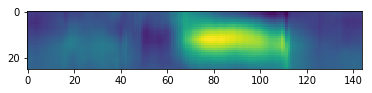

In [19]:
imshow(Covs_fromC)

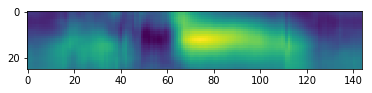

In [20]:
imshow(Corrs_fromC)

In [22]:
whos

Variable      Type       Data/Info
----------------------------------
CPAC          ndarray    240x1: 240 elems, type `float32`, 960 bytes
CfromE        ndarray    240x1: 240 elems, type `float32`, 960 bytes
Corrs_fromC   ndarray    25x144: 3600 elems, type `float64`, 28800 bytes
Corrs_fromE   ndarray    25x144: 3600 elems, type `float64`, 28800 bytes
Covs_fromC    ndarray    25x144: 3600 elems, type `float64`, 28800 bytes
Covs_fromE    ndarray    25x144: 3600 elems, type `float64`, 28800 bytes
Dataset       type       <class 'netCDF4._netCDF4.Dataset'>
EPAC          ndarray    240x1: 240 elems, type `float32`, 960 bytes
EfromC        ndarray    240x1: 240 elems, type `float32`, 960 bytes
Image         type       <class 'IPython.core.display.Image'>
calmo         ndarray    20: 20 elems, type `int64`, 160 bytes
calmos        ndarray    12: 12 elems, type `int64`, 96 bytes
cor           float32    0.64983976
datafile      Dataset    <object with id 4767153752 (str() failed)>
ilag       